## Read File

In [4]:
"test"

'test'

In [5]:
import pandas as pd

# CCBA_PATH = '../dataset/train_first/public_train_x_ccba_full_hashed.csv'
# CDTX_PATH = '../dataset/train_first/public_train_x_cdtx0001_full_hashed.csv'
# DP_PATH = '../dataset/train_first/public_train_x_dp_full_hashed.csv'
# REMIT_PATH = '../dataset/train_first/public_train_x_remit1_full_hashed.csv'
CUSTINFO_PATH = 'dataset/train_first/public_train_x_custinfo_full_hashed.csv'
PDATE_PATH = 'dataset/train_first/public_x_alert_date.csv'
TDATE_PATH = 'dataset/train_first/train_x_alert_date.csv'
ANSWER_PATH = 'dataset/train_first/train_y_answer.csv'
SAMPLE_PATH = 'dataset/train_first/sample_submission.csv'

# ccba = pd.read_csv(CCBA_PATH)
# cdtx = pd.read_csv(CDTX_PATH)
# dp = pd.read_csv(DP_PATH)
# remit = pd.read_csv(REMIT_PATH)
cinfo = pd.read_csv(CUSTINFO_PATH)
pdate = pd.read_csv(PDATE_PATH)
tdate = pd.read_csv(TDATE_PATH)
answer = pd.read_csv(ANSWER_PATH)
sample = pd.read_csv(SAMPLE_PATH)

In [6]:
pdate.head()

,alert_key,date
0,352342,365
1,352866,365
2,352696,365
3,352330,365
4,352683,365


In [7]:
# add data label
# pdate > public_x_alert_date is a test dataset
# tdate > train_x_alert_date is a train dataset
pdate.insert(pdate.shape[1], "data_label", ["test"] * pdate.shape[0], True)
tdate.insert(tdate.shape[1], "data_label", ["train"] * tdate.shape[0], True)
date = pd.concat([pdate, tdate], axis=0)
date.head()

,alert_key,date,data_label
0,352342,365,test
1,352866,365,test
2,352696,365,test
3,352330,365,test
4,352683,365,test


In [8]:
# check if the public date and sample submission is the same key
sample[sample['alert_key'].isin(pdate['alert_key'])]

,alert_key,probability
0,357307,0.000017
3,357668,0.000489
4,354443,0.000526
5,361128,0.000887
6,364753,0.001057
...,...,...
3842,357676,0.996705
3844,360534,0.997549
3845,364485,0.997702
3846,363155,0.998987


## Preprocess

In [9]:
import pandas as pd

In [10]:
# Map Date and target to 'cust_info'
cinfo = cinfo.merge(date, on='alert_key', how='left')
cinfo = cinfo.merge(answer, on='alert_key', how='left')

In [11]:
cinfo.head()

,alert_key,cust_id,risk_rank,occupation_code,total_asset,AGE,date,data_label,sar_flag
0,352249,82595ac69158ae08d34156784bdec0d9e2ca5b242b6d2a...,1,19.0,1465816.0,7,365,test,NaN
1,352253,b212d14cb35676926682b2cf849e295d948888f556c07e...,1,2.0,98177.0,2,365,test,NaN
2,352254,e5b0002791c7852644a2730abeaa893cdf14a072ef7812...,1,19.0,2052922.0,7,365,test,NaN
3,352280,74214c478dc6519fbefe4bc31693865bdcd698ab974b64...,3,15.0,201906.0,5,365,test,NaN
4,352282,0340e7611f0d82c3cb87e6194fa14bb2ccf8afbf1b3418...,1,12.0,7450.0,5,365,test,NaN


In [12]:
import copy

# separate
train_cinfo = copy.deepcopy(cinfo)
train_cinfo = train_cinfo[~pd.isna(train_cinfo['sar_flag'])]
train_cinfo.head()

,alert_key,cust_id,risk_rank,occupation_code,total_asset,AGE,date,data_label,sar_flag
1845,171142,a39fea9aec90969fe66a2b2b4d1b86368a2d38e8b8d4bf...,3,12.0,241719.0,3,0,train,0.0
1846,171152,7e42b5dca9b28ee8e5545beb834361e90e6197d176b389...,3,13.0,599497.0,6,0,train,0.0
1847,171177,a6cdf6302aead77112013168c6d546d2df3bcb551956d2...,1,19.0,51160.0,4,0,train,0.0
1848,171178,1a3efa69705f611c7ef2384a715c8142e2ee801cfec9df...,3,9.0,3634343.0,6,0,train,0.0
1849,171180,67f8cbb64dd3d447e992b1b299e0ceed3372188e47c88e...,1,17.0,4076287.0,4,0,train,0.0


In [13]:
mean_encoding_map = {}


def mean_encoding(key):
    key_map = {}
    keys = pd.unique(train_cinfo[key])  #[k for k in pd.unique(X_under[key]) if not (pd.isna(k))]
    for k in keys:
        if pd.isna(k):
            key_map[k] = 0
            continue
        is_sar_num = len((train_cinfo[(train_cinfo['sar_flag'] == 1.0) & (train_cinfo[key] == k)]))
        total_num = len(train_cinfo[train_cinfo[key] == k])
        mean_val = is_sar_num / total_num * 100
        key_map[k] = mean_val
    mean_encoding_map[key] = key_map


mean_encoding('AGE')
mean_encoding('risk_rank')
mean_encoding('date')
mean_encoding('occupation_code')
mean_encoding_map

{'AGE': {3: 1.1390728476821192,
  6: 0.5569306930693069,
  4: 0.8374384236453201,
  5: 0.7261724659606656,
  2: 1.2917115177610334,
  9: 0.0,
  1: 1.1363636363636365,
  7: 0.22522522522522523,
  8: 2.3529411764705883,
  10: 0.0,
  0: 0.0},
 'risk_rank': {3: 0.21413276231263384,
  1: 1.2931842318985445,
  2: 1.4423076923076923,
  0: 0.0},
 'date': {0: 1.1363636363636365,
  5: 0.6578947368421052,
  6: 0.0,
  7: 1.2048192771084338,
  8: 0.0,
  11: 0.0,
  12: 2.380952380952381,
  13: 0.4878048780487805,
  14: 2.127659574468085,
  15: 0.0,
  18: 0.9900990099009901,
  19: 1.1494252873563218,
  20: 0.0,
  21: 1.3157894736842104,
  22: 0.0,
  25: 0.847457627118644,
  26: 4.477611940298507,
  27: 2.197802197802198,
  28: 1.1627906976744187,
  32: 2.2058823529411766,
  33: 1.2987012987012987,
  34: 1.098901098901099,
  35: 1.2658227848101267,
  36: 3.7037037037037033,
  39: 1.8518518518518516,
  40: 1.2658227848101267,
  41: 3.7037037037037033,
  42: 2.197802197802198,
  43: 5.747126436781609,
 

In [14]:
for k, v in mean_encoding_map.items():
    mean_encoding_val = [0 if (pd.isna(x) or v.get(k) is None) else v[x] for x in cinfo[k]]
    column_name = k + "_encoding"
    cinfo = pd.concat([cinfo, pd.DataFrame({column_name: mean_encoding_val})], axis=1)

cinfo.head()

,alert_key,cust_id,risk_rank,occupation_code,total_asset,AGE,date,data_label,sar_flag,AGE_encoding,risk_rank_encoding,date_encoding,occupation_code_encoding
0,352249,82595ac69158ae08d34156784bdec0d9e2ca5b242b6d2a...,1,19.0,1465816.0,7,365,test,NaN,0,0,0,0
1,352253,b212d14cb35676926682b2cf849e295d948888f556c07e...,1,2.0,98177.0,2,365,test,NaN,0,0,0,0
2,352254,e5b0002791c7852644a2730abeaa893cdf14a072ef7812...,1,19.0,2052922.0,7,365,test,NaN,0,0,0,0
3,352280,74214c478dc6519fbefe4bc31693865bdcd698ab974b64...,3,15.0,201906.0,5,365,test,NaN,0,0,0,0
4,352282,0340e7611f0d82c3cb87e6194fa14bb2ccf8afbf1b3418...,1,12.0,7450.0,5,365,test,NaN,0,0,0,0


In [15]:
X = cinfo[cinfo['data_label'] == 'train']
len(X)

23906

In [16]:
test = cinfo[cinfo['data_label'] == 'test']
len(test)

1845

In [17]:
test_alert_keys = test['alert_key']
test_alert_keys.head()

0    352249
1    352253
2    352254
3    352280
4    352282
Name: alert_key, dtype: int64

In [18]:
test.head()

,alert_key,cust_id,risk_rank,occupation_code,total_asset,AGE,date,data_label,sar_flag,AGE_encoding,risk_rank_encoding,date_encoding,occupation_code_encoding
0,352249,82595ac69158ae08d34156784bdec0d9e2ca5b242b6d2a...,1,19.0,1465816.0,7,365,test,NaN,0,0,0,0
1,352253,b212d14cb35676926682b2cf849e295d948888f556c07e...,1,2.0,98177.0,2,365,test,NaN,0,0,0,0
2,352254,e5b0002791c7852644a2730abeaa893cdf14a072ef7812...,1,19.0,2052922.0,7,365,test,NaN,0,0,0,0
3,352280,74214c478dc6519fbefe4bc31693865bdcd698ab974b64...,3,15.0,201906.0,5,365,test,NaN,0,0,0,0
4,352282,0340e7611f0d82c3cb87e6194fa14bb2ccf8afbf1b3418...,1,12.0,7450.0,5,365,test,NaN,0,0,0,0


### Drop confusing customer id
1. get all alert flag where customer id is sar
2. remove all data where cust_id is in sar for non-sar record

In [19]:
sar_cust = X[X['sar_flag'] == 1]
sar_cust.head()

,alert_key,cust_id,risk_rank,occupation_code,total_asset,AGE,date,data_label,sar_flag,AGE_encoding,risk_rank_encoding,date_encoding,occupation_code_encoding
1926,171770,25cf26d9c40bb9f71292b809c4f92018b9bdfe3529c510...,1,17.0,1913895.0,4,0,train,1.0,0,0,0,0
2026,172480,7fde997da7e7a95280460889004bd2f23050bd8953de7e...,3,12.0,8251.0,4,5,train,1.0,0,0,0,0
2281,174298,bf19e3fe441d8dfa31794de3b4c318770ca7da5b4f5973...,1,19.0,186714.0,7,7,train,1.0,0,0,0,0
3443,177788,6400e6bb0fea2dc8410931f6eaf99e9513e4c025f9c9c2...,1,15.0,1744729.0,5,12,train,1.0,0,0,0,0
3479,177960,26eeff4dcdbf9ddb3e2628f8710a1e87b1ea53d37e0331...,1,9.0,238193.0,2,12,train,1.0,0,0,0,0


In [20]:
X = X[~X['cust_id'].isin(sar_cust.cust_id.tolist())]
X.shape

(23019, 13)

In [21]:
X = pd.concat([X, sar_cust])
X.head()

,alert_key,cust_id,risk_rank,occupation_code,total_asset,AGE,date,data_label,sar_flag,AGE_encoding,risk_rank_encoding,date_encoding,occupation_code_encoding
1845,171142,a39fea9aec90969fe66a2b2b4d1b86368a2d38e8b8d4bf...,3,12.0,241719.0,3,0,train,0.0,0,0,0,0
1846,171152,7e42b5dca9b28ee8e5545beb834361e90e6197d176b389...,3,13.0,599497.0,6,0,train,0.0,0,0,0,0
1847,171177,a6cdf6302aead77112013168c6d546d2df3bcb551956d2...,1,19.0,51160.0,4,0,train,0.0,0,0,0,0
1848,171178,1a3efa69705f611c7ef2384a715c8142e2ee801cfec9df...,3,9.0,3634343.0,6,0,train,0.0,0,0,0,0
1849,171180,67f8cbb64dd3d447e992b1b299e0ceed3372188e47c88e...,1,17.0,4076287.0,4,0,train,0.0,0,0,0,0


In [22]:
y = X['sar_flag']
y.shape

(23253,)

## Deal with imbalance problem
-  Over sampling
-  Under sampling

### Training XGBoost - Over sampling

In [23]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

X_smote_prep = copy.deepcopy(X)
X_smote_prep = X_smote_prep.dropna()
X_smote_prep = X_smote_prep.drop(['cust_id', 'data_label'], axis=1)
y_smote_prep = X_smote_prep['sar_flag']
X_smote, y_smote = smote.fit_resample(X_smote_prep, y_smote_prep)
X_smote.shape
X_smote[X_smote['sar_flag'] == 1.0].shape, X_smote[X_smote['sar_flag'] == 0.0].shape

((22903, 11), (22903, 11))

In [24]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.4,
                                                                            random_state=123)
X_train_smote.head()

,alert_key,risk_rank,occupation_code,total_asset,AGE,date,sar_flag,AGE_encoding,risk_rank_encoding,date_encoding,occupation_code_encoding
20012,328400,1,12.000000,500199.000000,2,323,0.0,0,0,0,0
13971,283603,1,13.000000,0.000000,3,244,0.0,0,0,0,0
40819,217909,1,18.082676,23269.224403,4,105,1.0,0,0,0,0
43705,242796,2,15.763528,85663.414263,3,160,1.0,0,0,0,0
20733,334830,1,7.000000,0.000000,5,335,0.0,0,0,0,0


In [25]:
import seaborn as sns
from sklearn.metrics import accuracy_score

In [26]:
drop_features_smote = ["alert_key", "sar_flag"]
X_train_smote = X_train_smote.drop(drop_features_smote, axis=1)
X_test_smote = X_test_smote.drop(drop_features_smote, axis=1)

(0.9908857719805708,
 array([[8908,   78],
        [  89, 9248]]))

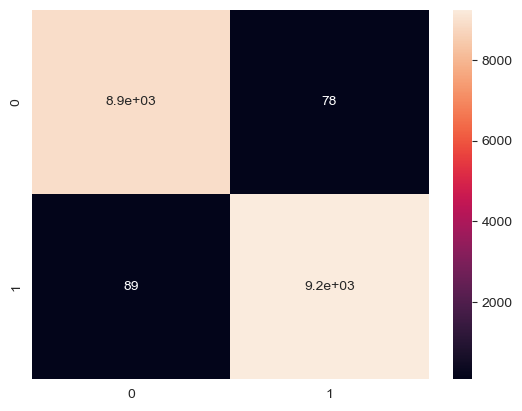

In [27]:
xg_cls_smote = xgb.XGBClassifier()
xg_cls_smote.fit(X_train_smote, y_train_smote)

cls_preds_smote = xg_cls_smote.predict(X_test_smote)

cm_smote = confusion_matrix(y_test_smote, cls_preds_smote)
sns.heatmap(cm_smote, annot=True)

accuracy_score(y_test_smote, cls_preds_smote), cm_smote

### Training XGBoost - Under sampling

In [28]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler()
X_under, y_under = undersample.fit_resample(X, y)

In [29]:
X_under.shape

(468, 13)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.2, random_state=123)

In [31]:
drop_features = ["alert_key", "cust_id", "data_label", "sar_flag", "date_encoding", "occupation_code_encoding"]
X_train = X_train.drop(drop_features, axis=1)
X_test = X_test.drop(drop_features, axis=1)
test = test.drop(drop_features, axis=1)

In [32]:
X_train.head()

,risk_rank,occupation_code,total_asset,AGE,date,AGE_encoding,risk_rank_encoding
148,3,17.0,57674.0,3,20,0,0
131,1,9.0,388751.0,3,273,0,0
437,1,17.0,72355.0,3,245,0,0
317,3,18.0,867571.0,3,71,0,0
400,3,18.0,84616.0,3,174,0,0


In [33]:
xg_cls = xgb.XGBClassifier()
xg_cls.fit(X_train, y_train)

cls_preds = xg_cls.predict(X_test)

0.7446808510638298

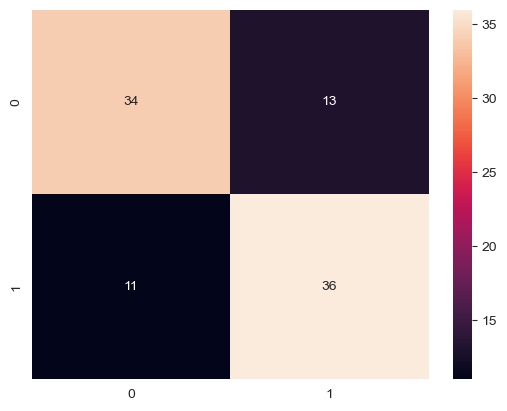

In [34]:
import seaborn as sns
from sklearn.metrics import accuracy_score

cm = confusion_matrix(y_test, cls_preds)
sns.heatmap(cm, annot=True)
accuracy_score(y_test, cls_preds)

In [43]:
prob_test = [prob[1] for prob in xg_cls.predict_proba(test).tolist()]
prob_test[:10]

[0.3380860388278961,
 0.9570350050926208,
 0.29421466588974,
 0.01930517889559269,
 0.021547846496105194,
 0.4741611182689667,
 0.006780773401260376,
 0.2988464832305908,
 0.10849740356206894,
 0.07116826623678207]

In [42]:
non_predicted_key = sample[~sample['alert_key'].isin(test_alert_keys)]
non_predicted_key = non_predicted_key.assign(probability=0)
non_predicted_key.shape

(2005, 2)

In [41]:
submission = pd.concat([test_alert_keys, pd.DataFrame({'probability': prob_test})], axis=1)
submission = submission.sort_values(by=['probability'], ascending=False)
submission = pd.concat([submission, non_predicted_key])
submission.shape, submission.head()

((3850, 2),
       alert_key  probability
 1512     362735     0.994571
 301      354810     0.994129
 461      355759     0.994129
 305      354818     0.988793
 811      357883     0.988793)

In [ ]:
submission.to_csv("submission_xgboost.csv", index=False)